In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
from tqdm.notebook import tqdm
from pathlib import Path
from rdkit import Chem

In [2]:
# Load all filtered parquet files and count actives per UniProt target
data_dir = Path("../data/chembl_affinity")

# Find all filtered parquet files
filtered_files = list(data_dir.glob("uniprot_*/*_chembl_activities_filtered.parquet"))
print(f"Found {len(filtered_files)} filtered parquet files")

# Count unique molecules (actives) per UniProt target
uniprot_counts = {}

for file_path in tqdm(filtered_files, desc="Loading filtered data"):
    # Extract UniProt ID from path
    uniprot_id = file_path.parent.name.replace("uniprot_", "")
    
    try:
        df = pd.read_parquet(file_path)
        # Count unique molecules (using InchiKey if available, else canonical_smiles)
        if 'InchiKey' in df.columns:
            n_actives = df['InchiKey'].nunique()
        elif 'canonical_smiles' in df.columns:
            n_actives = df['canonical_smiles'].nunique()
        else:
            n_actives = len(df)
        
        uniprot_counts[uniprot_id] = n_actives
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Convert to DataFrame and sort
counts_df = pd.DataFrame({
    'uniprot_id': list(uniprot_counts.keys()),
    'n_actives': list(uniprot_counts.values())
}).sort_values('n_actives', ascending=False)

print(f"\nLoaded data for {len(counts_df)} UniProt targets")
print(f"Total actives: {counts_df['n_actives'].sum():,}")
print(f"\nDistribution of actives per target:")
print(counts_df['n_actives'].describe())

Found 837 filtered parquet files


Loading filtered data:   0%|          | 0/837 [00:00<?, ?it/s]


Loaded data for 837 UniProt targets
Total actives: 280,028

Distribution of actives per target:
count     837.000000
mean      334.561529
std       398.935929
min         5.000000
25%        53.000000
50%       171.000000
75%       473.000000
max      2454.000000
Name: n_actives, dtype: float64


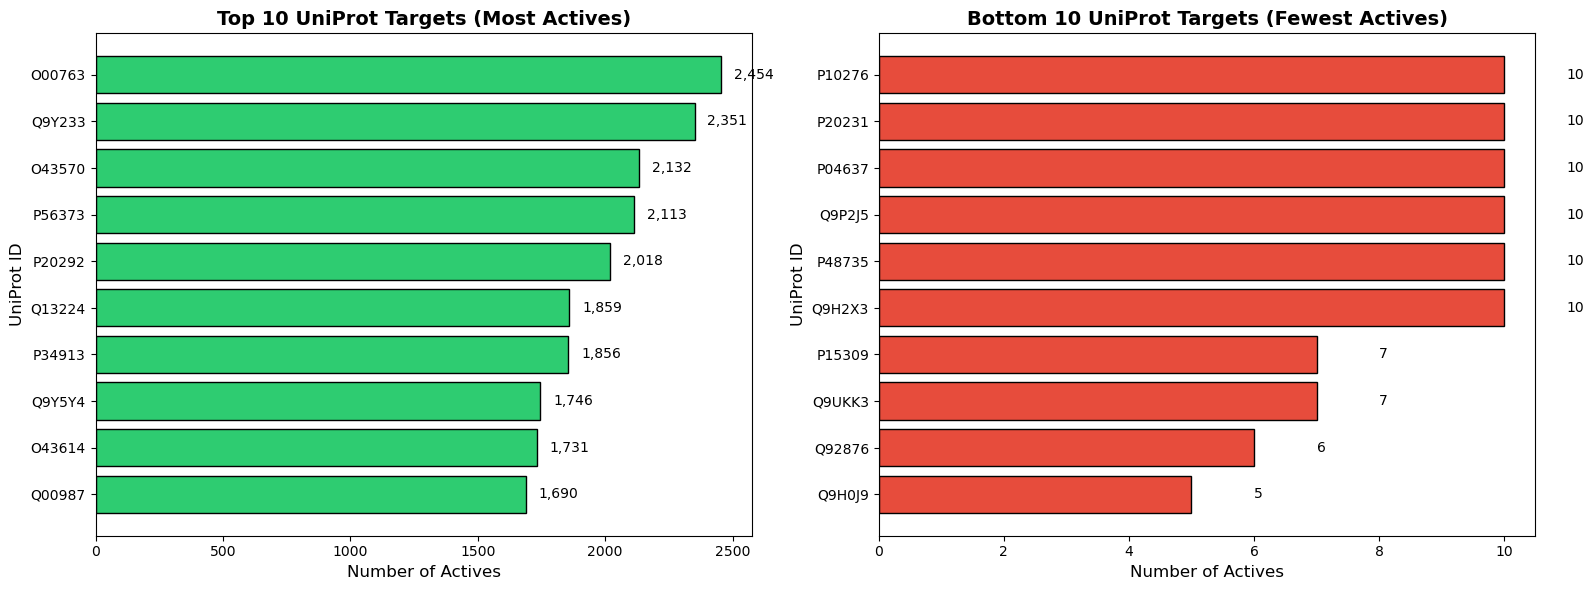


=== Top 10 UniProt Targets ===
uniprot_id  n_actives
    O00763       2454
    Q9Y233       2351
    O43570       2132
    P56373       2113
    P20292       2018
    Q13224       1859
    P34913       1856
    Q9Y5Y4       1746
    O43614       1731
    Q00987       1690

=== Bottom 10 UniProt Targets ===
uniprot_id  n_actives
    P10276         10
    P20231         10
    P04637         10
    Q9P2J5         10
    P48735         10
    Q9H2X3         10
    P15309          7
    Q9UKK3          7
    Q92876          6
    Q9H0J9          5


In [3]:
# Get top 10 and bottom 10 UniProt targets
top_10 = counts_df.head(10)
bottom_10 = counts_df.tail(10)

# Create side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 targets (most actives)
ax1 = axes[0]
bars1 = ax1.barh(top_10['uniprot_id'], top_10['n_actives'], color='#2ecc71', edgecolor='black')
ax1.set_xlabel('Number of Actives', fontsize=12)
ax1.set_ylabel('UniProt ID', fontsize=12)
ax1.set_title('Top 10 UniProt Targets (Most Actives)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()  # Highest at top

# Add value labels on bars
for bar, val in zip(bars1, top_10['n_actives']):
    ax1.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
             f'{val:,}', va='center', fontsize=10)

# Bottom 10 targets (fewest actives)
ax2 = axes[1]
bars2 = ax2.barh(bottom_10['uniprot_id'], bottom_10['n_actives'], color='#e74c3c', edgecolor='black')
ax2.set_xlabel('Number of Actives', fontsize=12)
ax2.set_ylabel('UniProt ID', fontsize=12)
ax2.set_title('Bottom 10 UniProt Targets (Fewest Actives)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()  # Maintain order

# Add value labels on bars
for bar, val in zip(bars2, bottom_10['n_actives']):
    ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{val:,}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../data/output/top_bottom_10_actives.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n=== Top 10 UniProt Targets ===")
print(top_10.to_string(index=False))
print("\n=== Bottom 10 UniProt Targets ===")
print(bottom_10.to_string(index=False))

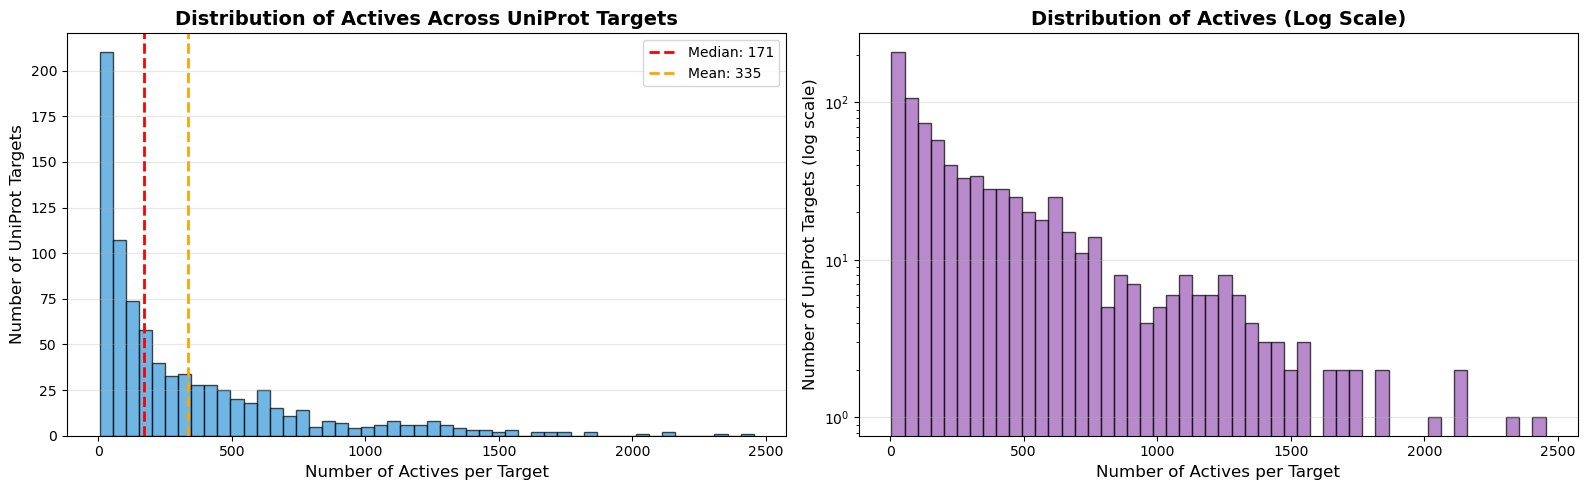

=== Distribution Statistics ===
Total UniProt targets: 837
Total actives: 280,028

Actives per target:
  Min:    5
  Max:    2,454
  Mean:   334.6
  Median: 171.0
  Std:    398.9

Percentiles:
  25th percentile: 53 actives
  50th percentile: 171 actives
  75th percentile: 473 actives
  90th percentile: 884 actives
  95th percentile: 1,224 actives
  99th percentile: 1,716 actives

Targets by active count range:
  0 - 100: 313 targets (37.4%)
  100 - 500: 325 targets (38.8%)
  500 - 1,000: 129 targets (15.4%)
  1,000 - 5,000: 70 targets (8.4%)
  5,000 - ∞: 0 targets (0.0%)


In [4]:
# Overall distribution of actives per UniProt target
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Histogram of active counts
ax1 = axes[0]
ax1.hist(counts_df['n_actives'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of Actives per Target', fontsize=12)
ax1.set_ylabel('Number of UniProt Targets', fontsize=12)
ax1.set_title('Distribution of Actives Across UniProt Targets', fontsize=14, fontweight='bold')
ax1.axvline(counts_df['n_actives'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {counts_df['n_actives'].median():,.0f}")
ax1.axvline(counts_df['n_actives'].mean(), color='orange', linestyle='--', linewidth=2, label=f"Mean: {counts_df['n_actives'].mean():,.0f}")
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Right: Log-scale histogram for better visualization of distribution
ax2 = axes[1]
ax2.hist(counts_df['n_actives'], bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Actives per Target', fontsize=12)
ax2.set_ylabel('Number of UniProt Targets (log scale)', fontsize=12)
ax2.set_title('Distribution of Actives (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/output/actives_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional statistics
print("=== Distribution Statistics ===")
print(f"Total UniProt targets: {len(counts_df)}")
print(f"Total actives: {counts_df['n_actives'].sum():,}")
print(f"\nActives per target:")
print(f"  Min:    {counts_df['n_actives'].min():,}")
print(f"  Max:    {counts_df['n_actives'].max():,}")
print(f"  Mean:   {counts_df['n_actives'].mean():,.1f}")
print(f"  Median: {counts_df['n_actives'].median():,.1f}")
print(f"  Std:    {counts_df['n_actives'].std():,.1f}")

# Percentile breakdown
print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    val = counts_df['n_actives'].quantile(p/100)
    print(f"  {p}th percentile: {val:,.0f} actives")

# Count targets in different ranges
ranges = [(0, 100), (100, 500), (500, 1000), (1000, 5000), (5000, float('inf'))]
print(f"\nTargets by active count range:")
for low, high in ranges:
    count = ((counts_df['n_actives'] >= low) & (counts_df['n_actives'] < high)).sum()
    pct = count / len(counts_df) * 100
    high_str = f"{high:,}" if high != float('inf') else "∞"
    print(f"  {low:,} - {high_str}: {count} targets ({pct:.1f}%)")

In [5]:
similarity_df = pd.read_parquet("../data/similarity_scores/overlap_pairwise_scores.parquet")
similarity_df

,query_system,target_system,tanimoto,sucos_protein_aligned,sucos_ligand_aligned,shape_similarity,alignment_rmsd,foldseek_lddt,error
0,8cjk__1__1.A__1.B_1.C,8yhw__1__1.A__1.E_1.F,0.524846,0.112774,0.239556,0.286105,0.516834,0.19510,None
1,8cjk__1__1.A__1.B_1.C,8ak8__1__1.A__1.C_1.F_1.L,0.544004,0.000000,0.285169,0.190400,0.592574,0.18680,None
2,8cjk__1__1.A__1.B_1.C,8f1g__1__1.A__1.C,0.299816,NaN,0.379077,0.364143,0.381887,NaN,None
3,8cjk__1__1.A__1.B_1.C,7xaa__1__1.A__1.C_1.D_1.E,0.503020,0.000000,0.312984,0.346510,0.632515,0.21370,None
4,8cjk__1__1.A__1.B_1.C,8ak5__1__1.A__1.C_1.E_1.F_1.G,0.545255,0.000000,0.252220,0.161029,0.576459,0.23950,None
...,...,...,...,...,...,...,...,...,...
181498,8ug1__1__1.B__1.H,7dn8__1__1.B__1.I_1.J,0.379459,0.000000,0.392903,0.321899,0.478790,0.25030,None
181499,8ug1__1__1.B__1.H,7mxn__1__1.A__1.C,0.427887,0.000000,0.392590,0.419891,0.452173,0.21250,None
181500,7t7m__1__1.A__1.I,7dn8__1__1.B__1.I_1.J,0.369419,NaN,0.275767,0.260707,0.308080,NaN,None
181501,7dn8__1__1.B__1.I_1.J,7mxn__1__1.A__1.C,0.529243,0.000000,0.491409,0.432621,0.227623,0.31510,None


In [6]:
# Get all unique systems from similarity_df
all_systems = set(similarity_df['query_system'].unique()) | set(similarity_df['target_system'].unique())
print(f"Total unique systems in similarity_df: {len(all_systems)}")

# Load annotation table to get UniProt mapping
annotation_df = pd.read_parquet("../data/annotation_table_with_uniprot.parquet")
print(f"Annotation table shape: {annotation_df.shape}")

# Get UniProt IDs that have filtered affinity data
filtered_uniprot_ids = set(counts_df['uniprot_id'].tolist())
print(f"UniProt IDs with filtered affinity data: {len(filtered_uniprot_ids)}")

Total unique systems in similarity_df: 603
Annotation table shape: (114537, 750)
UniProt IDs with filtered affinity data: 837


In [7]:
# Map systems to UniProt IDs
# Filter annotation table to only systems in similarity_df
systems_in_similarity = annotation_df[annotation_df['system_id'].isin(all_systems)].copy()
print(f"Systems from similarity_df found in annotation table: {len(systems_in_similarity)}")

# Extract UniProt IDs for each system
def extract_uniprot_ids(uniprot_ids):
    """Extract UniProt IDs from the column (may be list, array, or string)."""
    # Handle None/NaN
    if uniprot_ids is None:
        return []
    # Handle numpy arrays and lists first (before pd.isna which fails on arrays)
    if isinstance(uniprot_ids, (list, np.ndarray)):
        return list(uniprot_ids)
    # Now safe to check for scalar NaN
    try:
        if pd.isna(uniprot_ids):
            return []
    except (ValueError, TypeError):
        pass
    # Handle string representation of list
    if isinstance(uniprot_ids, str):
        if uniprot_ids.startswith('['):
            try:
                return eval(uniprot_ids)
            except:
                return []
        return [uniprot_ids]
    return []

systems_in_similarity['uniprot_list'] = systems_in_similarity['uniprot_ids'].apply(extract_uniprot_ids)

# Check which systems have UniProt IDs with affinity data
def has_affinity_data(uniprot_list):
    """Check if any UniProt ID has filtered affinity data."""
    return any(uid in filtered_uniprot_ids for uid in uniprot_list)

systems_in_similarity['has_affinity_data'] = systems_in_similarity['uniprot_list'].apply(has_affinity_data)

# Get the primary UniProt ID (first one with affinity data)
def get_primary_uniprot_with_affinity(uniprot_list):
    """Get the first UniProt ID that has affinity data."""
    for uid in uniprot_list:
        if uid in filtered_uniprot_ids:
            return uid
    return None

systems_in_similarity['primary_uniprot'] = systems_in_similarity['uniprot_list'].apply(get_primary_uniprot_with_affinity)

# Summary
systems_with_affinity = systems_in_similarity[systems_in_similarity['has_affinity_data']]
print(f"\nSystems with affinity data: {len(systems_with_affinity)} / {len(systems_in_similarity)}")
print(f"Unique UniProt IDs represented: {systems_with_affinity['primary_uniprot'].nunique()}")

# Show distribution
print("\nSystems per UniProt (top 10):")
print(systems_with_affinity.groupby('primary_uniprot').size().sort_values(ascending=False).head(10))

Systems from similarity_df found in annotation table: 652

Systems with affinity data: 580 / 652
Unique UniProt IDs represented: 189

Systems per UniProt (top 10):
primary_uniprot
Q9Y233    76
P03372    18
Q9H999    18
Q8N6T7    16
Q8N884    15
O14744    12
P00533    12
Q08499    10
P17752     9
Q03181     8
dtype: int64


In [8]:
# Create a mapping from system_id to primary_uniprot for joining with similarity_df
system_to_uniprot = systems_with_affinity.set_index('system_id')['primary_uniprot'].to_dict()

# Add UniProt IDs to similarity_df
similarity_df['query_uniprot'] = similarity_df['query_system'].map(system_to_uniprot)
similarity_df['target_uniprot'] = similarity_df['target_system'].map(system_to_uniprot)

# Filter to pairs where both systems have affinity data
similarity_with_affinity = similarity_df[
    similarity_df['query_uniprot'].notna() & 
    similarity_df['target_uniprot'].notna()
].copy()

print(f"Similarity pairs with affinity data for both systems: {len(similarity_with_affinity)} / {len(similarity_df)}")
print(f"\nQuery UniProts: {similarity_with_affinity['query_uniprot'].nunique()}")
print(f"Target UniProts: {similarity_with_affinity['target_uniprot'].nunique()}")

# Show sample
print("\nSample of similarity pairs with UniProt mapping:")
similarity_with_affinity[['query_system', 'query_uniprot', 'target_system', 'target_uniprot', 'tanimoto']].head(10)

Similarity pairs with affinity data for both systems: 144991 / 181503

Query UniProts: 189
Target UniProts: 189

Sample of similarity pairs with UniProt mapping:


,query_system,query_uniprot,target_system,target_uniprot,tanimoto
0,8cjk__1__1.A__1.B_1.C,P17752,8yhw__1__1.A__1.E_1.F,Q99558,0.524846
1,8cjk__1__1.A__1.B_1.C,P17752,8ak8__1__1.A__1.C_1.F_1.L,Q8N6T7,0.544004
2,8cjk__1__1.A__1.B_1.C,P17752,8f1g__1__1.A__1.C,P61964,0.299816
3,8cjk__1__1.A__1.B_1.C,P17752,7xaa__1__1.A__1.C_1.D_1.E,Q08499,0.503020
4,8cjk__1__1.A__1.B_1.C,P17752,8ak5__1__1.A__1.C_1.E_1.F_1.G,Q8N6T7,0.545255
5,8cjk__1__1.A__1.B_1.C,P17752,8f1z__1__1.A__1.B,P00533,0.574153
6,8cjk__1__1.A__1.B_1.C,P17752,8fe9__1__1.A__1.B,Q07912,0.426690
7,8cjk__1__1.A__1.B_1.C,P17752,8ou2__1__1.A__1.C,Q12830,0.557808
8,8cjk__1__1.A__1.B_1.C,P17752,8cij__1__1.A__1.B,Q92918,0.593882
9,8cjk__1__1.A__1.B_1.C,P17752,7e5g__1__1.A_2.A__2.B,Q07869,0.305389


Available similarity columns: ['tanimoto', 'sucos_protein_aligned', 'sucos_ligand_aligned', 'shape_similarity']


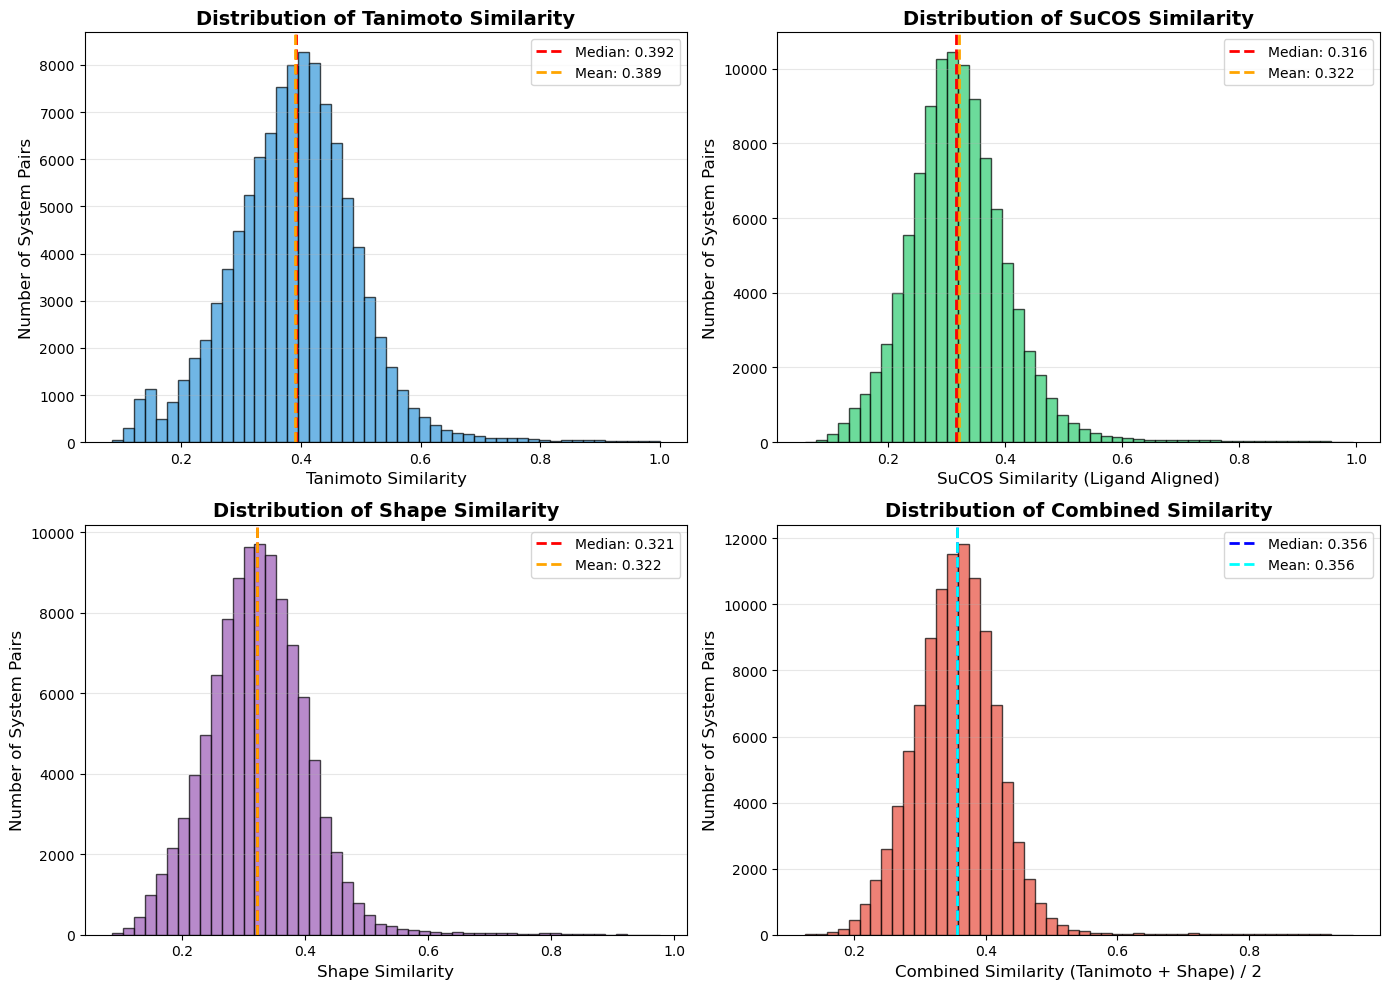


=== Similarity Metrics Summary ===
Total system pairs with affinity data: 144991

Tanimoto Similarity:
  Mean: 0.3893
  Median: 0.3918
  Std: 0.1059
  Range: [0.0841, 1.0000]

SuCOS Similarity (sucos_ligand_aligned):
  Mean: 0.3216
  Median: 0.3161
  Std: 0.0880
  Range: [0.0576, 0.9938]

Shape Similarity (shape_similarity):
  Mean: 0.3225
  Median: 0.3211
  Std: 0.0819
  Range: [0.0860, 0.9767]


In [29]:
# Visualize distribution of similarity metrics for systems with affinity data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Check available columns
print("Available similarity columns:", [c for c in similarity_with_affinity.columns if 'tanimoto' in c.lower() or 'sucos' in c.lower() or 'shape' in c.lower()])

# 1. Tanimoto similarity distribution
ax1 = axes[0, 0]
ax1.hist(similarity_with_affinity['tanimoto'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(similarity_with_affinity['tanimoto'].median(), color='red', linestyle='--', linewidth=2, 
            label=f"Median: {similarity_with_affinity['tanimoto'].median():.3f}")
ax1.axvline(similarity_with_affinity['tanimoto'].mean(), color='orange', linestyle='--', linewidth=2,
            label=f"Mean: {similarity_with_affinity['tanimoto'].mean():.3f}")
ax1.set_xlabel('Tanimoto Similarity', fontsize=12)
ax1.set_ylabel('Number of System Pairs', fontsize=12)
ax1.set_title('Distribution of Tanimoto Similarity', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# 2. SuCOS ligand-aligned similarity distribution
ax2 = axes[0, 1]
if 'sucos_ligand_aligned' in similarity_with_affinity.columns:
    sucos_col = 'sucos_ligand_aligned'
elif 'sucos' in similarity_with_affinity.columns:
    sucos_col = 'sucos'
else:
    sucos_col = [c for c in similarity_with_affinity.columns if 'sucos' in c.lower()][0] if any('sucos' in c.lower() for c in similarity_with_affinity.columns) else None

if sucos_col:
    ax2.hist(similarity_with_affinity[sucos_col], bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
    ax2.axvline(similarity_with_affinity[sucos_col].median(), color='red', linestyle='--', linewidth=2,
                label=f"Median: {similarity_with_affinity[sucos_col].median():.3f}")
    ax2.axvline(similarity_with_affinity[sucos_col].mean(), color='orange', linestyle='--', linewidth=2,
                label=f"Mean: {similarity_with_affinity[sucos_col].mean():.3f}")
    ax2.set_xlabel('SuCOS Similarity (Ligand Aligned)', fontsize=12)
    ax2.set_ylabel('Number of System Pairs', fontsize=12)
    ax2.set_title('Distribution of SuCOS Similarity', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'SuCOS column not found', ha='center', va='center', fontsize=14)

# 3. Shape similarity distribution
ax3 = axes[1, 0]
if 'shape_similarity' in similarity_with_affinity.columns:
    shape_col = 'shape_similarity'
elif 'shape' in similarity_with_affinity.columns:
    shape_col = 'shape'
else:
    shape_col = [c for c in similarity_with_affinity.columns if 'shape' in c.lower()][0] if any('shape' in c.lower() for c in similarity_with_affinity.columns) else None

if shape_col:
    ax3.hist(similarity_with_affinity[shape_col], bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
    ax3.axvline(similarity_with_affinity[shape_col].median(), color='red', linestyle='--', linewidth=2,
                label=f"Median: {similarity_with_affinity[shape_col].median():.3f}")
    ax3.axvline(similarity_with_affinity[shape_col].mean(), color='orange', linestyle='--', linewidth=2,
                label=f"Mean: {similarity_with_affinity[shape_col].mean():.3f}")
    ax3.set_xlabel('Shape Similarity', fontsize=12)
    ax3.set_ylabel('Number of System Pairs', fontsize=12)
    ax3.set_title('Distribution of Shape Similarity', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(axis='y', alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Shape similarity column not found', ha='center', va='center', fontsize=14)

# 4. Combined metric: Tanimoto + Shape (average or weighted)
ax4 = axes[1, 1]
if shape_col:
    # Create combined metric (average of Tanimoto and Shape similarity)
    similarity_with_affinity['combined_similarity'] = (
        similarity_with_affinity['tanimoto'] + similarity_with_affinity[shape_col]
    ) / 2
    
    ax4.hist(similarity_with_affinity['combined_similarity'], bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
    ax4.axvline(similarity_with_affinity['combined_similarity'].median(), color='blue', linestyle='--', linewidth=2,
                label=f"Median: {similarity_with_affinity['combined_similarity'].median():.3f}")
    ax4.axvline(similarity_with_affinity['combined_similarity'].mean(), color='cyan', linestyle='--', linewidth=2,
                label=f"Mean: {similarity_with_affinity['combined_similarity'].mean():.3f}")
    ax4.set_xlabel('Combined Similarity (Tanimoto + Shape) / 2', fontsize=12)
    ax4.set_ylabel('Number of System Pairs', fontsize=12)
    ax4.set_title('Distribution of Combined Similarity', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(axis='y', alpha=0.3)
else:
    ax4.hist(similarity_with_affinity['tanimoto'], bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
    ax4.set_xlabel('Tanimoto Similarity', fontsize=12)
    ax4.set_ylabel('Number of System Pairs', fontsize=12)
    ax4.set_title('Tanimoto (Shape not available)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/output/similarity_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Similarity Metrics Summary ===")
print(f"Total system pairs with affinity data: {len(similarity_with_affinity)}")
print(f"\nTanimoto Similarity:")
print(f"  Mean: {similarity_with_affinity['tanimoto'].mean():.4f}")
print(f"  Median: {similarity_with_affinity['tanimoto'].median():.4f}")
print(f"  Std: {similarity_with_affinity['tanimoto'].std():.4f}")
print(f"  Range: [{similarity_with_affinity['tanimoto'].min():.4f}, {similarity_with_affinity['tanimoto'].max():.4f}]")

if sucos_col:
    print(f"\nSuCOS Similarity ({sucos_col}):")
    print(f"  Mean: {similarity_with_affinity[sucos_col].mean():.4f}")
    print(f"  Median: {similarity_with_affinity[sucos_col].median():.4f}")
    print(f"  Std: {similarity_with_affinity[sucos_col].std():.4f}")
    print(f"  Range: [{similarity_with_affinity[sucos_col].min():.4f}, {similarity_with_affinity[sucos_col].max():.4f}]")

if shape_col:
    print(f"\nShape Similarity ({shape_col}):")
    print(f"  Mean: {similarity_with_affinity[shape_col].mean():.4f}")
    print(f"  Median: {similarity_with_affinity[shape_col].median():.4f}")
    print(f"  Std: {similarity_with_affinity[shape_col].std():.4f}")
    print(f"  Range: [{similarity_with_affinity[shape_col].min():.4f}, {similarity_with_affinity[shape_col].max():.4f}]")